# Activity 2 Logistic Regression for classification

<img src="./tec_logo.png" width="auto" height="200" />

**Marcos Dayan Mann**
 
A01782876

Deliver date: September 3rd, 2025

# Logistic Regression — Cancer Classification

This Jupyter notebook implements different Logistic Regression machine learning models, first with several manual implementations with a sigmoidal activaton, then proposing a new activation function using the hyperbolit tangent, and varying the epoch and learning rate, and finally, using a sklearn LogisticRegression model. 

The models will be trained on the breast cancer dataset, and we will evaluate the following criteria:
- Manual gradient ascent logistic regression with a sigmoidal activation
- Alternative activation (tanh) for comparison in prediction.
- Manual gradient ascent with learning-rate from 0.01 to 0.30, and with epochs from 1 to 150.
- SKlearn gradient ascent with C value [0.1, 0.5, 1.0], and with epochs from 31 to 150.
- Insights, metrics and confusion matrices for both of the models


## Install required dependencies

In [1]:
import sys
!{sys.executable} -m pip install scikit-learn numpy pandas plotly


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.4.1/libexec/bin/python -m pip install --upgrade pip


## Importing dependencies at the top so we don't have to be importing in each code block

In [2]:
import math
import codecs
import csv

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_curve, auc, precision_recall_curve

## Reading both the training and testing dataset and adapting as in HW points 1 and 2
I realized that converting a matrix into a np array eases a lot operating with the dataset and performing operations with it

Another option can be with pandas, but I prefer using numpy as it includes more utilities to treat the data as matrixes, operating, and passing arguments as lambda functions and list comprehensions to its fiunctions

In [3]:
train_path = "cancer_training.csv"
test_path = "cancer_test.csv"

import numpy as np

def load_cancer_csv(path):
    with open(path, newline="") as f:
        reader = csv.reader(f)
        data = [row for row in reader]
    
    data = np.array(data)
    X = data[:, :-1].astype(float)
    y_raw = data[:, -1]
    
    y = np.array([0.0 if val.lower() in ["benign","b","0"]
                  else 1.0 for val in y_raw])
    
    return X, y

X_train, y_train = load_cancer_csv(train_path)
X_test,  y_test  = load_cancer_csv(test_path)

feature_number = X_train.shape[1]

X_train

array([[2., 3., 1., ..., 1., 1., 1.],
       [4., 4., 4., ..., 2., 1., 1.],
       [7., 5., 3., ..., 7., 5., 5.],
       ...,
       [4., 1., 2., ..., 3., 1., 1.],
       [4., 6., 6., ..., 7., 7., 3.],
       [2., 1., 1., ..., 3., 1., 1.]], shape=(599, 9))

## Sigmoid activation function for classifying

In [4]:
def sigmoid(z):
    return 1 / (1 + math.exp(-z))

## Model training functions

In [5]:
def gradient(vector, weights, activation_function=sigmoid):
    """This function calculates the predicted h0 for a vector given some thetas (weights)"""
    sum_elements = 0.0
    for x, w in zip(vector, weights):
        sum_elements += (x * w)
    return activation_function(sum_elements)


def classify_list(vector, weights, activation_function=sigmoid):
    """This function wraps the previous one, just it rounds the activation function result"""
    probability = gradient(vector, weights, activation_function)
    return 1.0 if probability > 0.5 else 0.0


def stochastic_gradient_ascent(training_lists, training_labels, feature_number, learning_rate=0.01, iterations=150, activation_function=sigmoid):
    #Get the number of training samples
    sample_number = len(training_lists)

    #Create a list of N fatures (featureNumber) for saving optimal weights (1.0 as initial value)
    weights = [1.0] * feature_number

    #Iterate a fixed number of times for getting optimal weights
    for it in range(iterations):

        #Get the index number of training samples
        sample_index = list(range(sample_number))

        #For each training sample do the following
        for idx in range(sample_number):

            """
            Alpha is the learning rate and controls how much the coefficients (and therefore the model)
            changes or learns each time it is updated.

            Alpha decreases as the number of iterations increases, but it never reaches 0
            """
            alpha = 4/(1.0 + it + idx) + learning_rate

            #Randomly obtain an index of one of training samples
            """
            Here, you’re randomly selecting each instance to use in updating the weights.
            This will reduce the small periodic variations that can be present if we analyze
            everything sequentially
            """
            rand_idx = int(np.random.uniform(0, len(sample_index)))

            #Obtain the gradient from the current training sample and weights
            sample_gradient = gradient(training_lists[rand_idx], weights, activation_function=activation_function)

            #Check the error rate
            error = training_labels[rand_idx] - sample_gradient

            """
            we are calculating the error between the actual class and the predicted class and
            then moving in the direction of that error (CURRENT TRAINING PROCESS)
            """
            temp = []
            for j in range(feature_number):
                temp.append(alpha * (error * training_lists[rand_idx][j]))

            for j in range(feature_number):
                weights[j] += temp[j]

            # remove sampled index
            del sample_index[rand_idx]

    return np.array(weights, dtype=float)


## Manual model test case

In [6]:
weights = stochastic_gradient_ascent(X_train.tolist(), y_train.tolist(), feature_number, 0.01, 150)

# Predictions
y_pred_manual = np.array([classify_list(x, weights) for x in X_test])

# Metrics
acc_manual = accuracy_score(y_test, y_pred_manual)
prec_manual = precision_score(y_test, y_pred_manual, zero_division=0)
rec_manual = recall_score(y_test, y_pred_manual, zero_division=0)
cm_manual = confusion_matrix(y_test, y_pred_manual)

print("Manual Sigmoid — Accuracy:", acc_manual)
print("Manual Sigmoid — Precision:", prec_manual)
print("Manual Sigmoid — Recall:", rec_manual)
print("Manual Sigmoid — Confusion Matrix:\n", cm_manual)


Manual Sigmoid — Accuracy: 0.84
Manual Sigmoid — Precision: 0.9166666666666666
Manual Sigmoid — Recall: 0.4230769230769231
Manual Sigmoid — Confusion Matrix:
 [[73  1]
 [15 11]]


## Tanh activation function (HW point 3)

In [7]:
def tanh_activation(z):
    return 0.5 * (np.tanh(z)+1.0)

## Manual model training using tanh activation function

In [8]:
weights = stochastic_gradient_ascent(X_train.tolist(), y_train.tolist(), feature_number, 0.01, 150, activation_function=tanh_activation)


y_pred_tanh = np.array([classify_list(x, weights, activation_function=tanh_activation) for x in X_test])
acc_tanh = accuracy_score(y_test, y_pred_tanh)
prec_tanh = precision_score(y_test, y_pred_tanh, zero_division=0)
rec_tanh = recall_score(y_test, y_pred_tanh, zero_division=0)
cm_tanh = confusion_matrix(y_test, y_pred_tanh)

print("Manual Tanh — Accuracy:", acc_tanh)
print("Manual Tanh — Precision:", prec_tanh)
print("Manual Tanh — Recall:", rec_tanh)
print("Manual Tanh — Confusion Matrix:\n", cm_tanh)


Manual Tanh — Accuracy: 0.83
Manual Tanh — Precision: 0.8
Manual Tanh — Recall: 0.46153846153846156
Manual Tanh — Confusion Matrix:
 [[71  3]
 [14 12]]


## Custom training model function with custom parameters

In [9]:
def train_model_return_results(X, y, X_test, y_test, feature_num, alpha, epochs, activation_function):
    """This function wrapps a manual statistic regression classification model training given a custom dataset with n variables, epochs, alpha, and a custom activation function.
    It returns the trained weights, the trained predictions, the accuracy score, precision score, recall score, and a confusin matrix
    """
    weights = stochastic_gradient_ascent(X, y, feature_num, alpha, epochs, activation_function=activation_function)

    y_pred = np.array([classify_list(x, weights, activation_function=activation_function) for x in X_test])
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)

    return weights, y_pred, acc, prec, rec, cm

## Class to wrap the statistic regression result for performing several test cases

In [10]:
class StatisticRegressionResult:
    def __init__(self, feature_num, alpha, epochs, activation_function_name, weights, y_pred, acc, prec, rec, cm):
        self.feature_num = feature_num
        self.alpha = alpha
        self.epochs = epochs
        self.activation_function_name = activation_function_name
        self.weights = weights
        self.y_pred = y_pred
        self.acc = acc
        self.prec = prec
        self.rec = rec
        self.cm = cm

    def __lt__(self, other):
        f1_self = 0.0 if (self.prec + self.rec) == 0 else (2 * self.prec * self.rec) / (self.prec + self.rec)
        f1_other = 0.0 if (other.prec + other.rec) == 0 else (2 * other.prec * other.rec) / (other.prec + other.rec)
        return f1_self < f1_other

    def __str__(self):
        return f'{self.feature_num}, {self.alpha}, {self.epochs}, {self.activation_function_name}, {self.weights}, {self.acc}, {self.prec}, {self.rec}, {self.cm}'

## Orchestrate different model training with varying parameters in order to find the best hyperparameter combination (HW point 4)

### Manual model orchestration


In [11]:
manual_results = [] # will store 4500 results

X_train_list = X_train.tolist()
y_train_list = y_train.tolist()

average_cm = np.zeros((2,2), dtype=float)


for epoch in range(1, 151): # 1, 151
    for a in range(1, 2): # 1, 31
        alpha = a/100
        weights, y_pred, acc, prec, rec, cm = train_model_return_results(X_train_list, y_train_list, X_test, y_test, feature_number, alpha, epoch, activation_function=tanh_activation)
        manual_results.append(StatisticRegressionResult(feature_number, alpha, epoch, 'tanh', weights, y_pred, acc, prec, rec, cm))
        average_cm += cm


sorted_manual_results = sorted(manual_results, reverse=True)

average_cm = (average_cm / len(manual_results)).astype(int)

plot_10_manual_results = sorted_manual_results[:5] + sorted_manual_results[-5:]

### SKlearn model orchestration

In [12]:
sklearn_results = [] # will store 357 results
average_sklearn_cm = np.zeros((2,2), dtype=float)


for epoch in range(31, 150): # if using a lower iteration number, sklearn throws a warning in which the model could not converge
    for c in [1.0, 0.5, 0.1]:
        model = LogisticRegression(max_iter=epoch, C=c)
        model.fit(X_train, y_train)
        y_pred_sklearn = model.predict(X_test)
        acc_sk = accuracy_score(y_test, y_pred_sklearn)
        prec_sk = precision_score(y_test, y_pred_sklearn, zero_division=0)
        rec_sk = recall_score(y_test, y_pred_sklearn, zero_division=0)
        cm_sk = confusion_matrix(y_test, y_pred_sklearn)

        sklearn_results.append(StatisticRegressionResult(9, c, epoch, '', [], y_pred_sklearn, acc_sk, prec_sk, rec_sk, cm_sk))
        average_sklearn_cm += cm_sk


sorted_sklearn_results = sorted(sklearn_results, reverse=True)

average_sklearn_cm = (average_sklearn_cm / len(sklearn_results)).astype(int)

plot_10_sklearn_results = sorted_sklearn_results[:5] + sorted_sklearn_results[-5:]


## Confussion matrix plot for best manual and SKlearn model, and for avergage manual and SKlearn models across different epoch and learning rate ranges

## Plotting and comparing results with a confusion matrix (HW point 5)

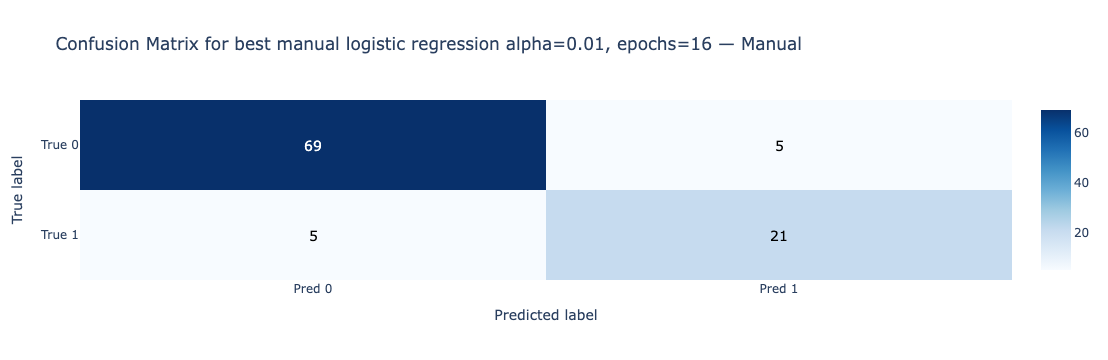

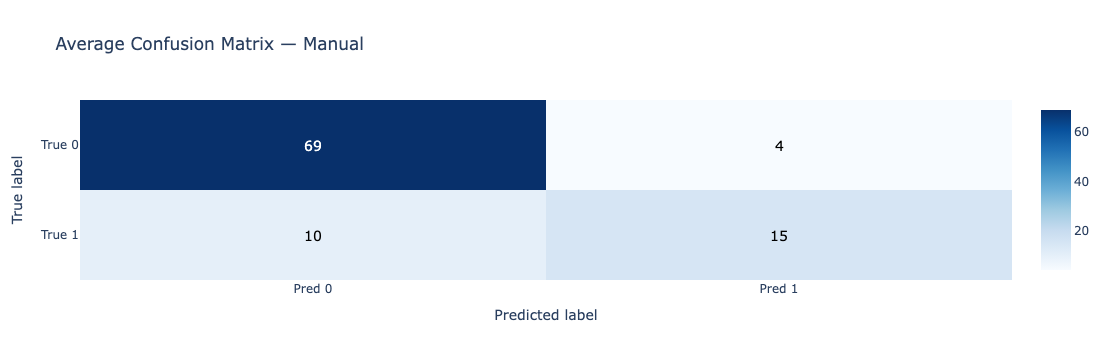

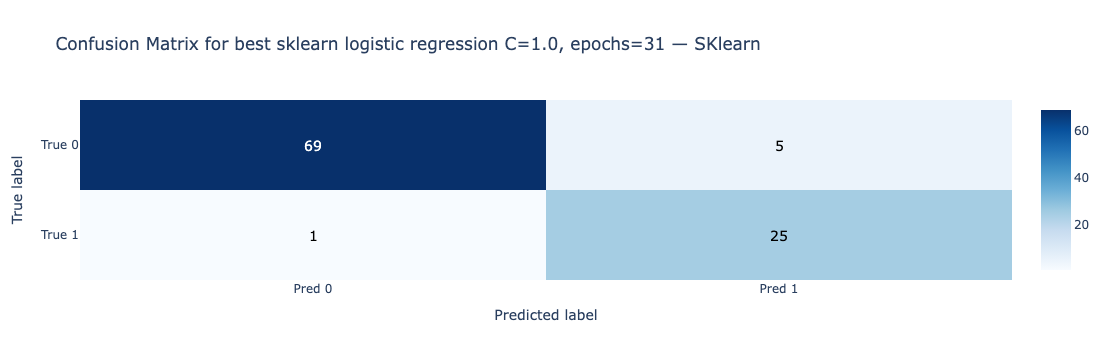

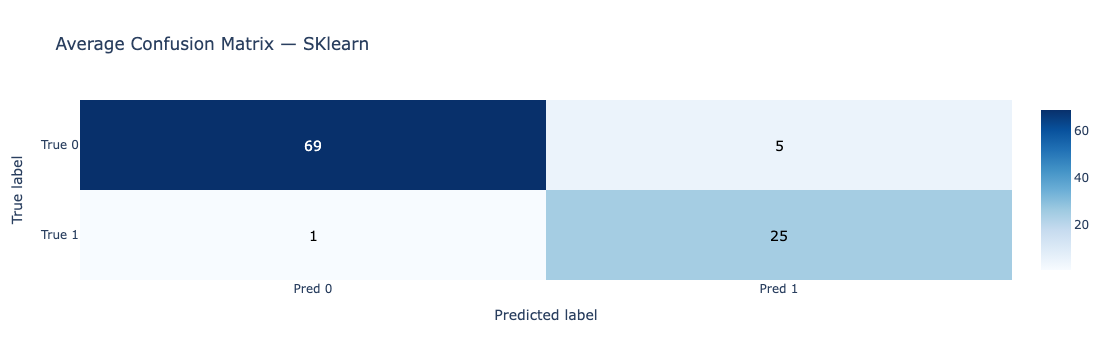

In [14]:
def plot_confusion_matrix_plotly(cm, title):
    fig = go.Figure(data=go.Heatmap(
        z=cm,
        x=['Pred 0','Pred 1'],
        y=['True 0','True 1'],
        showscale=True,
        colorscale="Blues",
        hovertemplate='Row %{y}<br>Col %{x}<br>Count %{z}<extra></extra>'
    ))
    max_val = cm.max()
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = cm[i, j]
            font_color = "white" if val > max_val/2 else "black"
            fig.add_annotation(
                x=['Pred 0','Pred 1'][j],
                y=['True 0','True 1'][i],
                text=str(cm[i, j]),
                showarrow=False,
                font=dict(size=14, color=font_color)
            )
    fig.update_layout(
        title=title,
        xaxis_title="Predicted label",
        yaxis_title="True label",
        yaxis_autorange='reversed'
    )
    fig.show()

plot_confusion_matrix_plotly(plot_10_manual_results[0].cm,   f"Confusion Matrix for best manual logistic regression alpha={plot_10_manual_results[0].alpha}, epochs={plot_10_manual_results[0].epochs} — Manual")
plot_confusion_matrix_plotly(average_cm,   "Average Confusion Matrix — Manual")
plot_confusion_matrix_plotly(plot_10_sklearn_results[0].cm,   f"Confusion Matrix for best sklearn logistic regression C={plot_10_sklearn_results[0].alpha}, epochs={plot_10_sklearn_results[0].epochs} — SKlearn")
plot_confusion_matrix_plotly(average_sklearn_cm,   "Average Confusion Matrix — SKlearn")


### Helper function to convert object lists into plottable data

In [15]:
def to_lists(results):
    """This function turns class data to list to plot it"""
    acc = np.array([r.acc for r in results], dtype=float)
    prec = np.array([r.prec for r in results], dtype=float)
    rec = np.array([r.rec for r in results], dtype=float)
    # safe F1
    f1 = np.array([0.0 if (p + r_) == 0 else (2*p*r_/(p + r_)) for p, r_ in zip(prec, rec)], dtype=float)
    labels = [f"#{i+1} α={r.alpha}, ep={r.epochs}" for i, r in enumerate(results)]
    return {"acc": acc, "prec": prec, "rec": rec, "f1": f1, "labels": labels}

manual = to_lists(plot_10_manual_results)
skl    = to_lists(plot_10_sklearn_results)

# convenience for 'best' element (index 0)
best_manual  = plot_10_manual_results[0]
best_skl     = plot_10_sklearn_results[0]


## Comparisson for F1 metric in manual and sklearn 5 best and 5 worse models with varying alpha, epochs and C for SKlearn (HW point 6)

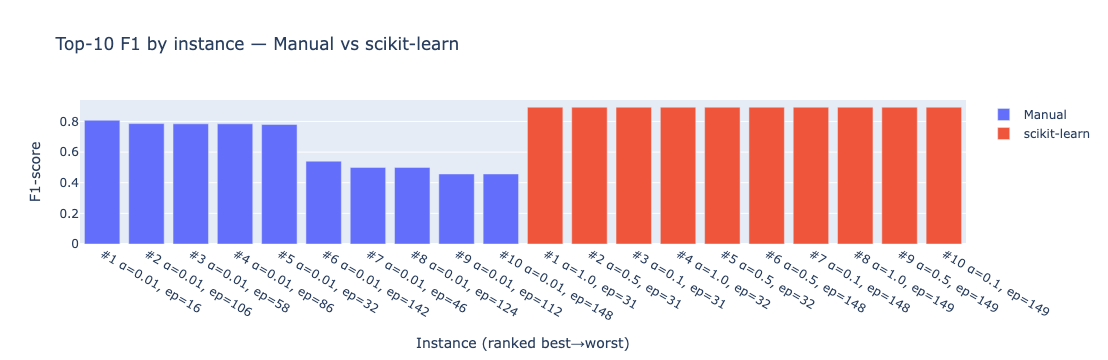

In [16]:
fig_f1_top10 = go.Figure()
fig_f1_top10.add_bar(name="Manual",  x=manual["labels"], y=manual["f1"])
fig_f1_top10.add_bar(name="scikit-learn", x=skl["labels"], y=skl["f1"])
fig_f1_top10.update_layout(
    title="Top-10 F1 by instance — Manual vs scikit-learn",
    xaxis_title="Instance (ranked best→worst)",
    yaxis_title="F1-score",
    barmode="group"
)
fig_f1_top10.show()


## Precision vs recall for each model (HW point 6)

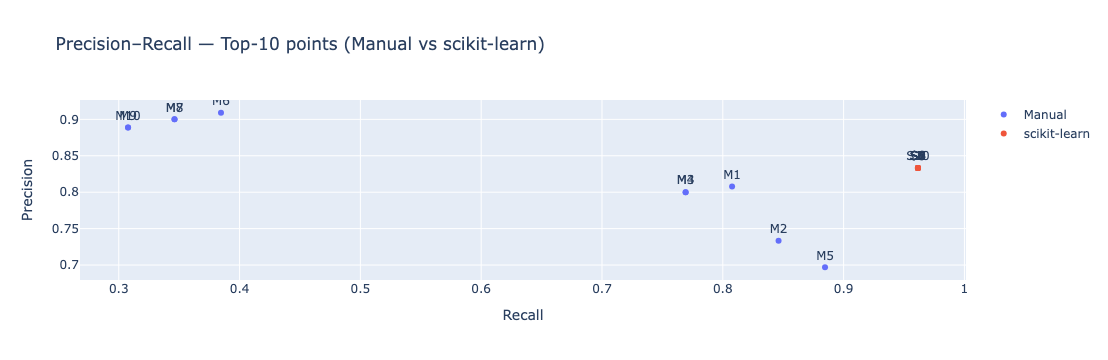

In [17]:
fig_pr_scatter = go.Figure()

fig_pr_scatter.add_trace(go.Scatter(
    x=manual["rec"], y=manual["prec"], mode="markers+text",
    name="Manual",
    text=[f"M{i+1}" for i in range(len(manual["rec"]))],
    textposition="top center"
))
fig_pr_scatter.add_trace(go.Scatter(
    x=skl["rec"], y=skl["prec"], mode="markers+text",
    name="scikit-learn",
    text=[f"S{i+1}" for i in range(len(skl["rec"]))],
    textposition="top center"
))

fig_pr_scatter.update_layout(
    title="Precision–Recall — Top-10 points (Manual vs scikit-learn)",
    xaxis_title="Recall",
    yaxis_title="Precision"
)
fig_pr_scatter.show()


## Accuracy across epochs for manual and sklearn models (HW point 6)

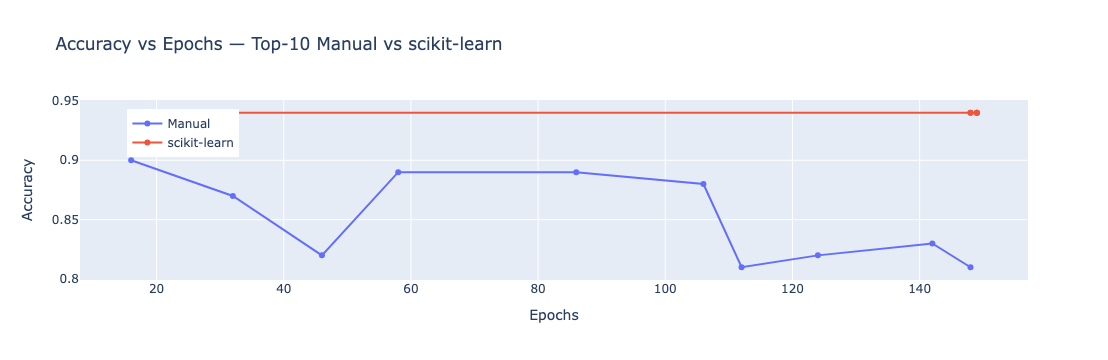

In [18]:
fig_acc_epochs = go.Figure()

fig_acc_epochs.add_trace(go.Scatter(
    x=[r.epochs for r in sorted(plot_10_manual_results, key=lambda x: x.epochs)],
    y=[r.acc for r in sorted(plot_10_manual_results, key=lambda x: x.epochs)],
    mode="markers+lines",
    name="Manual"
))

fig_acc_epochs.add_trace(go.Scatter(
    x=[r.epochs for r in sorted(plot_10_sklearn_results, key=lambda x: x.epochs)],
    y=[r.acc for r in sorted(plot_10_sklearn_results, key=lambda x: x.epochs)],
    mode="markers+lines",
    name="scikit-learn"
))

fig_acc_epochs.update_layout(
    title="Accuracy vs Epochs — Top-10 Manual vs scikit-learn",
    xaxis_title="Epochs",
    yaxis_title="Accuracy",
    legend=dict(x=0.05, y=0.95)
)

fig_acc_epochs.show()



## Recall and Specificity comparisson between best manual and best sklearn model (HW point 6)

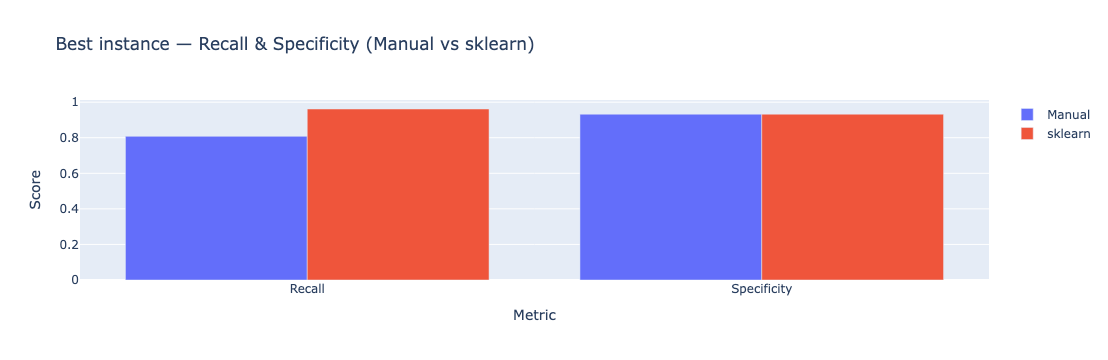

In [19]:
def sens_spec(cm):
    tn, fp = cm[0,0], cm[0,1]
    fn, tp = cm[1,0], cm[1,1]
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0    # sensitivity
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    return recall, specificity

rec_m, spec_m = sens_spec(best_manual.cm)
rec_s, spec_s = sens_spec(best_skl.cm)

metrics = ["Recall", "Specificity"]
manual_vals = [rec_m, spec_m]
skl_vals    = [rec_s, spec_s]

fig_sensspec = go.Figure()
fig_sensspec.add_bar(name="Manual",  x=metrics, y=manual_vals)
fig_sensspec.add_bar(name="sklearn", x=metrics, y=skl_vals)
fig_sensspec.update_layout(
    title="Best instance — Recall & Specificity (Manual vs sklearn)",
    xaxis_title="Metric",
    yaxis_title="Score",
    barmode="group"
)
fig_sensspec.show()


## Conclusions (HW point 7)

This projects gave me several insights to compare between both of the different model implementations, and the variation of epochs and alpha/C. In this case, we could see that the SKlearn implementation performed way better than the manual model implementation, this, because searching through the SKlearn docs, the LogisticRegression, dynamically fixes the learning rate to go through the least posible epoch number, besides, it performs way more efficiently because it calculates the least error possible by operating with matrixes.

Talking about the activtion function, the sigmoidal vs the tanh, I found out almost the same results between both of them, this function do not implies any performance change between the models.

Also I consider that the epoch range for this experiment was very limited, I consider we could achieve better results by increasing the epoch number, but because of the several manual test cases with varying hyperparameters, we maintained the epoch number with small number ranges.

On the other hand, I consider we could achieve a better error minimization by instead of performing gradient ascend, performing gradient desdend. In this way, we could compute the error on each epoch to plot it and analyze how does it change between epochs.

Finally, I saw advantaje of using predefined models as the SKlearn LogisticRegression because it handles and maximizes performance with the given hyperparameters and training data, adapting to it and dynamically adjusting other hyperparameters as for example the learning rate. With this we could achieve a way better model performance than with the manual models.
